# Code to compare compute and time resource cost between cpu and gpu
- uses output from pytorch_test_cpu,gpu.py
- CC node: cedar1
- CC gpu: Tesla P100-PCIE-12GB

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

In [2]:
project_dir = '../'
data_dir = '{}data/'.format(project_dir)
results_dir = '{}results/'.format(project_dir)

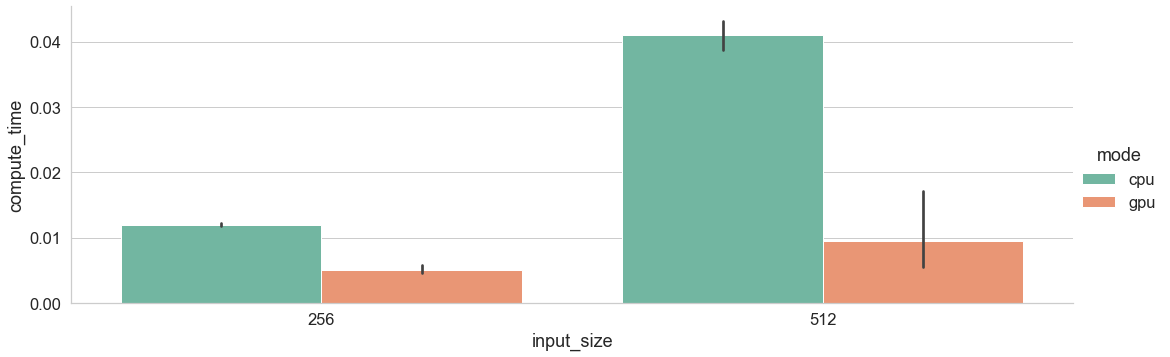

In [6]:
cpu_output_csv = '{}cpu_output.csv'.format(results_dir)
cpu_output_csv_2 = '{}cpu_output_2.csv'.format(results_dir)
gpu_output_csv = '{}gpu_output.csv'.format(results_dir)
gpu_output_csv_2 = '{}gpu_output_2.csv'.format(results_dir)

cpu_perf_df = pd.read_csv(cpu_output_csv)
cpu_perf_df['mode'] = 'cpu'
gpu_perf_df = pd.read_csv(gpu_output_csv)
gpu_perf_df['mode'] = 'gpu'

cpu_perf_df_2 = pd.read_csv(cpu_output_csv_2)
cpu_perf_df_2['mode'] = 'cpu'
gpu_perf_df_2 = pd.read_csv(gpu_output_csv_2)
gpu_perf_df_2['mode'] = 'gpu'

plot_df = cpu_perf_df.append(gpu_perf_df).append(cpu_perf_df_2).append(gpu_perf_df_2)

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='compute_time', x='input_size', hue='mode', kind='bar', data=plot_df, palette='Set2', aspect=3)
